In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This notebook is a revised version of notebook from [Rajesh Thallam](https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/vertex_endpoints/nvidia-triton/nvidia-triton-custom-container-prediction.ipynb)

# E2E ML on GCP: MLOps stage 6 : serving: get started with NVIDIA Triton server

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/ml_ops/stage6/get_started_with_nvidia_triton_serving.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/ml_ops/stage6/get_started_with_nvidia_triton_serving.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/ml_ops/stage6/get_started_with_nvidia_triton_serving.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

## Overview

This tutorial demonstrates how to deploy a `Vertex AI Model` resource to a [NVIDIA Triton Inference Server (Triton)](https://developer.nvidia.com/nvidia-triton-inference-server), and make online predictions using [Vertex AI Prediction](https://cloud.google.com/vertex-ai/docs/predictions/getting-predictions).

### Dataset

The tutorial uses Faster R-CNN with ResNet-101 v1 object detection model provided on [TensorFlow Hub](https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1) that has been trained on the [COCO 2017 dataset](https://cocodataset.org/#download) with training images scaled to 640x640.

### Objective

In this tutorial, you deploy a container running Nvidia Triton Server with a `Vertex AI Model` resource to a `Vertex AI Endpoint` for making online predictions.

This tutorial uses the following Google Cloud ML services:

- `Vertex AI Model`
- `Vertex AI Endpoint`
- `Vertex AI Prediction`
- `Google Artifact Registry`

The steps performed in this tutorial include:

- Download the model artifacts from TensorFlow Hub.
- Create Triton serving configuration file for the model.
- Construct a custom container, with Triton serving image, for model deployment.
- Upload the model as a `Vertex AI Model` resource.
- Deploy the `Vertex AI Model` resource to a `Vertex AI Endpoint` resource.
- Make a prediction request
- Undeploy the `Model` resource and delete the `Endpoint`

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Installations

Install the packages required for executing this notebook.

In [ ]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

! pip3 install --upgrade google-cloud-aiplatform $USER_FLAG -q

### Restart the kernel

Once you've installed the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### GPU runtime

*Make sure you're running this notebook in a GPU runtime if you have that option. In Colab, select* **Runtime > Change Runtime Type > GPU**

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the following APIs: Vertex AI APIs, Compute Engine APIs, and Cloud Storage.](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component,storage-component.googleapis.com)

4. If you are running this notebook locally, you will need to install the [Cloud SDK]((https://cloud.google.com/sdk)).

5. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$`.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

In [ ]:
! gcloud config set project $PROJECT_ID

#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "[your-region]"  # @param {type: "string"}

if REGION == "[your-region]":
    REGION = "us-central1"

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append the timestamp onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your Google Cloud account

**If you are using Google Cloud Notebooks**, your environment is already authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

In the Cloud Console, go to the [Create service account key](https://console.cloud.google.com/apis/credentials/serviceaccountkey) page.

**Click Create service account**.

In the **Service account name** field, enter a name, and click **Create**.

In the **Grant this service account access to project** section, click the Role drop-down list. Type "Vertex" into the filter box, and select **Vertex Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

Click Create. A JSON file that contains your key downloads to your local environment.

Enter the path to your service account key as the GOOGLE_APPLICATION_CREDENTIALS variable in the cell below and run the cell.

In [ ]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

import os
import sys

# If on Vertex AI Workbench, then don't execute this code
IS_COLAB = False
if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
    "DL_ANACONDA_HOME"
):
    if "google.colab" in sys.modules:
        IS_COLAB = True
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a custom training job using the Vertex client library for Python, you upload a Python package
containing your training code to a Cloud Storage bucket. Vertex AI runs
the code from this package. In this tutorial, Vertex AI also saves the
trained model that results from your job in the same bucket. You can then
create an `Endpoint` resource based on this output in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.

In [ ]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "aip-" + TIMESTAMP
    BUCKET_URI = "gs://" + BUCKET_NAME

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION $BUCKET_URI

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_URI

### Set up variables

Next, set up some variables used throughout the tutorial.

### Import libraries

In [ ]:
import json
import os
from pathlib import Path

import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from google.api import httpbody_pb2
from google.cloud import aiplatform as aiplatform
from google.cloud import aiplatform_v1 as gapic
from PIL import Image

### Define constants

`MODEL_ARTIFACTS_REPOSITORY` is a root Cloud Storage location where the Triton model artifacts will be stored.

In [ ]:
MODEL_ARTIFACTS_REPOSITORY = f"{BUCKET_URI}/triton-on-vertex/models"

The following set of constants will be used to create names and display names of Vertex AI Prediction resources like models, endpoints, and model deployments.

In [ ]:
# set model names and version
MODEL_NAME = "faster-rcnn"
MODEL_VERSION = "v01"
MODEL_DISPLAY_NAME = f"triton-{MODEL_NAME}-{MODEL_VERSION}_{TIMESTAMP}"
ENDPOINT_DISPLAY_NAME = f"endpoint-{MODEL_NAME}-{MODEL_VERSION}_{TIMESTAMP}"

# You can get the latest Triton image uri from
# https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver
NGC_TRITON_IMAGE_URI = "nvcr.io/nvidia/tritonserver:22.01-py3"

# prediction container image name
IMAGE_NAME = "vertex-triton-inference:22.01"

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [ ]:
aiplatform.init(project=PROJECT_ID, staging_bucket=BUCKET_URI)

#### Set hardware accelerators

You can set hardware accelerators for training and prediction.

Set the variables `TRAIN_GPU/TRAIN_NGPU` to use a container image supporting a GPU and the number of GPUs allocated to the virtual machine (VM) instance. For example, to use a GPU container image with 4 Nvidia Telsa T4 GPUs allocated to each VM, you would specify:

    (aip.AcceleratorType.NVIDIA_TESLA_T4, 4)

Otherwise specify `(None, None)` to use a container image to run on a CPU.

Learn more about [hardware accelerator support for your region](https://cloud.google.com/vertex-ai/docs/general/locations#accelerators).

In [ ]:
if os.getenv("IS_TESTING_TRAIN_GPU"):
    TRAIN_GPU, TRAIN_NGPU = (
        gapic.AcceleratorType.NVIDIA_TESLA_T4,
        int(os.getenv("IS_TESTING_TRAIN_GPU")),
    )
else:
    TRAIN_GPU, TRAIN_NGPU = (gapic.AcceleratorType.NVIDIA_TESLA_T4, 1)

#### Set machine type

Next, set the machine type to use for training.

- Set the variable `TRAIN_COMPUTE` to configure  the compute resources for the VMs you will use for for training.
 - `machine type`
     - `n1-standard`: 3.75GB of memory per vCPU.
     - `n1-highmem`: 6.5GB of memory per vCPU
     - `n1-highcpu`: 0.9 GB of memory per vCPU
 - `vCPUs`: number of \[2, 4, 8, 16, 32, 64, 96 \]

*Note: The following is not supported for training:*

 - `standard`: 2 vCPUs
 - `highcpu`: 2, 4 and 8 vCPUs

*Note: You may also use n2 and e2 machine types for training and deployment, but they do not support GPUs*.

In [ ]:
if os.getenv("IS_TESTING_TRAIN_MACHINE"):
    MACHINE_TYPE = os.getenv("IS_TESTING_TRAIN_MACHINE")
else:
    MACHINE_TYPE = "n1-standard"

VCPU = "4"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

## NVIDIA Triton Inference Server (Triton) Overview

[NVIDIA Triton Inference Server (Triton)](https://github.com/triton-inference-server/server) provides an inference solution optimized for both CPUs and GPUs. Triton can run multiple models from the same or different frameworks concurrently on a single GPU or CPU. In a multi-GPU server, it automatically creates an instance of each model on each GPU to increase utilization without extra coding. It supports real-time inferencing, batch inferencing to maximize GPU/CPU utilization, and streaming inference with built-in support for audio streaming input. It also supports model ensembles for use cases that require multiple models to perform end-to-end inference.

The following figure shows the Triton's high-level architecture.

![Triton high level architecture](https://raw.githubusercontent.com/triton-inference-server/server/main/docs/images/arch.jpg)

- The model repository is a file-system based repository of the models that Triton will make available for inference.
- Inference requests arrive at the server via either HTTP/REST or gRPC and are then routed to the appropriate per-model scheduler.
- Triton implements multiple scheduling and batching algorithms that can be configured on a model-by-model basis.
- The backend performs inference using the inputs provided in the batched requests to produce the requested outputs.

Triton provides readiness and liveness health endpoints, as well as utilization, throughput, and latency metrics, which enable the integration of Triton into deployment environments, such as Vertex AI Prediction.

Refer to [Triton architecture](https://github.com/triton-inference-server/server/blob/main/docs/architecture.md) for more detailed information.

## Triton on Vertex AI Prediction

Triton inference server runs inside a container published by NVIDIA GPU Cloud (NGC) - [NVIDIA Triton Inference Server Image](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver). NVIDIA and GCP Vertex AI team collaborated and added packages and configurations to align Triton with Vertex AI [requirements for custom serving container images](https://cloud.google.com/vertex-ai/docs/predictions/custom-container-requirements).

The model to be served by Triton should be registered with Vertex AI as a `Model` resource. The `Model`'s metadata refer to a location of the ensemble artifacts in Google Cloud Storage (GCS) and the custom serving container including configuration.

Triton loads the models and exposes inference, health, and model management REST endpoints using [standard inference protocols](https://github.com/kserve/kserve/tree/master/docs/predict-api/v2). While deploying to Vertex AI, Triton recognizes Vertex AI environment and adopts Vertex AI Prediction protocol for [health checks](https://cloud.google.com/vertex-ai/docs/predictions/custom-container-requirements#health) and predictions.

To invoke the model through the Vertex AI Prediction endpoint, format prediction request using a [standard Inference Request JSON Object](https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md#inference) or a [Inference Request JSON Object with a binary extension](https://github.com/triton-inference-server/server/blob/main/docs/protocol/extension_binary_data.md) and submit a request to Vertex AI Prediction [REST rawPredict endpoint](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/projects.locations.endpoints/rawPredict). You need to use the `rawPredict` rather than `predict` endpoint because inference request formats used by Triton are not compatible with the Vertex AI Prediction [standard input format](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models#formatting-prediction-input).

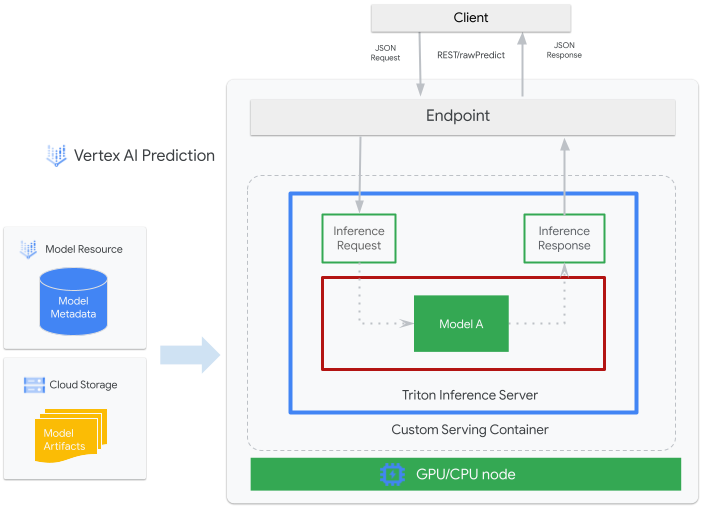

## Download model artifacts

For this tutorial, download the object detection model provided on [TensorFlow Hub](https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1) that has been trained on the [COCO 2017 dataset](https://cocodataset.org/#download). Triton expects [model repository]() to be organized in the following structure for serving [TensorFlow `SavedModel`](https://www.tensorflow.org/guide/saved_model) formats:

> ```
> └── model-repository-path
>        └── model_name
>               ├── config.pbtxt
>               └── 1
>                   └── model.savedmodel
>                         └── <saved-model-files>
> ```


The `config.pbtxt` file describes the [model configuration](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md) for the model.

In [ ]:
# download and organize model artifacts as per Triton model repository spec
! mkdir -p models/object_detector/1/model.savedmodel/
! curl -L "https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1?tf-hub-format=compressed" | \
    tar -zxvC ./models/object_detector/1/model.savedmodel/
! ls -ltr ./models/object_detector/1/model.savedmodel/

After downloading the model locally, model repository will be organized as following:

> ```
> ./models
> └── object_detector
>     └── 1
>         └── model.savedmodel
>             ├── saved_model.pb
>             └── variables
>                 ├── variables.data-00000-of-00001
>                 └── variables.index
> ```

In [ ]:
!tree ./models

### Create model configuration file

The [model configuration](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md) file `config.pbtxt` provides information about the model such as inputs and outputs. Refer to the [Triton docs](https://github.com/triton-inference-server/common/blob/main/protobuf/model_config.proto) for the configuration format. For TensorFlow models, you can use the [`saved_model_cli` command](https://www.tensorflow.org/guide/saved_model#details_of_the_savedmodel_command_line_interface) and map to the Triton's configuration format. 

*Note:* Triton datatypes are different from the frameworks and should be mapped accordingly based on the table [here](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md#datatypes).

For example: DT_UINT8 -> TYPE_UINT8

In [ ]:
!saved_model_cli show --dir ./models/object_detector/1/model.savedmodel/ --all

In [ ]:
%%writefile ./models/object_detector/config.pbtxt

name: "object_detector"
platform: "tensorflow_savedmodel"
backend: "tensorflow"
max_batch_size: 0
input [
  {
    name: "input_tensor"
    data_type: TYPE_UINT8
    dims: [ 1, -1, -1, 3 ]
  }
]
output [
  {
    name: "detection_anchor_indices"
    data_type: TYPE_FP32
    dims: [ 1, 300 ]
  },
  {
    name: "detection_boxes"
    data_type: TYPE_FP32
    dims: [ 1, 300, 4 ]
  },
  {
    name: "detection_classes"
    data_type: TYPE_FP32
    dims: [ 1, 300 ]
  },
  {
    name: "detection_multiclass_scores"
    data_type: TYPE_FP32,
    dims: [ 1, 300, 91]
  },
  {
    name: "detection_scores"
    data_type: TYPE_FP32
    dims: [ 1, 300 ]
  },
  {
    name: "num_detections"
    data_type: TYPE_FP32
    dims: [ 1 ]
  },
  {
    name: "raw_detection_boxes"
    data_type: TYPE_FP32
    dims: [ 1, 300, 4 ]
  },
  {
    name: "raw_detection_scores"
    data_type: TYPE_FP32
    dims: [ 1, 300, 91 ]
  }
]

### Push model artifacts to a Cloud Storage bucket

The downloaded model artifacts including model configuration file are pushed to a Cloud Storage bucket defined by `MODEL_ARTIFACTS_REPOSITORY` which will be used when uploading the model artifacts to a `Vertex AI Model` resource.

In [ ]:
! gsutil cp -r ./models/object_detector $MODEL_ARTIFACTS_REPOSITORY/

! gsutil ls -r $MODEL_ARTIFACTS_REPOSITORY/object_detector/

### Download test image file and generate payload to make prediction requests

The following function downloads a test image file, formats the request payload as JSON file that will be passed to prediction requests.

In [ ]:
def generate_payload(image_url):
    # download image to memory and resize
    image_inputs = Image.open(requests.get(image_url, stream=True).raw).resize(
        (200, 200)
    )
    # convert image to numpy array
    image_tensor = np.asarray(image_inputs)
    # derive image shape
    image_shape = [1] + list(image_tensor.shape)

    # create/set directory to save payload
    base = Path("./test")
    base.mkdir(exist_ok=True)

    # create payload request for Nvidia Triton server
    payload = {
        "id": "0",
        "inputs": [
            {
                "name": "input_tensor",
                "shape": image_shape,
                "datatype": "UINT8",
                "parameters": {},
                "data": image_tensor.tolist(),
            }
        ],
    }

    # save payload as json file
    payload_file = os.path.join(base, "payload.json")
    with open(payload_file, "w") as f:
        json.dump(payload, f)
    print(f"Payload generated at {payload_file}")

    return payload_file

### Download and view the sample image

In [ ]:
# set image url
image_url = "https://github.com/tensorflow/models/raw/master/research/object_detection/test_images/image2.jpg"

# show image
image = Image.open(requests.get(image_url, stream=True).raw).resize((200, 200))
image

### Format the request payload as JSON

In [ ]:
# format payload as JSON
payload_file = generate_payload(image_url)

print(payload_file)

### Make a prediction locally

Next, make a prediction with a local instance of the object detection model downloaded from TensorFlow Hub on the test image

In [ ]:
# download the model
detector = hub.load("https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1")

# download the image
image = Image.open(requests.get(image_url, stream=True).raw).resize((200, 200))

# convert image to a tensor using `tf.convert_to_tensor`
image_tensor = tf.convert_to_tensor(np.asarray(image))

# model expects an image batch, for single image add an axis with `tf.newaxis`
image_tensor = image_tensor[tf.newaxis, ...]

# run inference
detector_output = detector(image_tensor)

# return class_ids
class_ids = detector_output["detection_classes"]
print(class_ids)

## Building and pushing the container image

To use a custom container for serving predictions, you must specify a Docker container image that meets the [custom container requirements](https://cloud.google.com/vertex-ai/docs/predictions/custom-container-requirements). This section describes how to create the container image running Nvidia Triton Server and push it to `Google Artifact Registry` (GAR). 

The `Google Artifact Registry` is a service for storing and managing artifacts in private repositories, including container images, Helm charts, and language packages. It is the recommended container image registry for Google Cloud.

Learn more about [Quick start for Docker](https://cloud.google.com/artifact-registry/docs/docker/quickstart)

### Enable Artifact Registry API

First, you must enable the Artifact Registry API service for your project.

Learn more about [Enabling service](https://cloud.google.com/artifact-registry/docs/enable-service).

In [ ]:
! gcloud services enable artifactregistry.googleapis.com

### Create a private Docker repository to push the container images

Next, create your own private repository in `Artifact Registry` for your container image.

In [ ]:
DOCKER_ARTIFACT_REPO = "triton-prediction-container"

# create a new Docker repository with your region with the description
! gcloud artifacts repositories create {DOCKER_ARTIFACT_REPO} \
    --repository-format=docker \
    --location={REGION} \
    --description="Triton Docker repository"

# verify that your repository was created.
! gcloud artifacts repositories list \
    --location={REGION} \
    --filter="name~"{DOCKER_ARTIFACT_REPO}

### Configure authentication to your private repo

Before you push or pull container images, configure Docker to use the `gcloud` command-line tool to authenticate requests to `Artifact Registry` for your region.

In [ ]:
! gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet

### Registering the Nvidia Triton Server container

#### Name the container to register

Next, you will provide a name for your custom container that you will use when you submit it to the `Artifact Registry`.

In [ ]:
DEPLOY_IMAGE = (
    f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{DOCKER_ARTIFACT_REPO}/{IMAGE_NAME}"
)

#### Fetch and tag the Nvidia Triton Server container

Next, fetch (pull) a copy of the Nvidia Triton Server container and tag the copy for registering in `Artifact Registry`

In [ ]:
if not IS_COLAB:
    ! docker pull $NGC_TRITON_IMAGE_URI
    ! docker tag $NGC_TRITON_IMAGE_URI $DEPLOY_IMAGE
else:
    # install docker daemon
    ! apt-get -qq install docker.io

### Run the container locally *[optional]*

Before pushing the custom container image to `Artifact Registry` to use it with `Vertex AI Predictions`, run the container in local environment to verify that the server responds to prediction instances.

1. To run the container image as a container locally, run the following command:

**NOTE:** You can ignore error `No such container` which is thrown when the container is not running.

In [ ]:
if not IS_COLAB:
    ! docker stop local_object_detector
    ! docker run -t -d -p 8000:8000 --rm \
        --name=local_object_detector \
        -e AIP_MODE=True \
        $DEPLOY_IMAGE \
        --model-repository $MODEL_ARTIFACTS_REPOSITORY
    ! sleep 20

In [ ]:
if not IS_COLAB:
    # check if the triton container is running locally
    ! docker container ls -f"name=local_object_detector" --no-trunc

2. To send the container's server a health check, run the following command. It should return the status code as `200`.

*Note:* You are using the v2 API for Nvidia Triton Server -- which is the latest version.

In [ ]:
if not IS_COLAB:
    ! curl -s -o /dev/null -w "%{http_code}" http://localhost:8000/v2/health/ready

3. To send the container's server a prediction request, run the following command with sample image file as the payload and get prediction responses

In [ ]:
if not IS_COLAB:
    # request prediction response
    ! curl -X POST -H "Content-Type: application/octet-stream" \
        -H "Accept: */*" \
        --data-binary @$payload_file \
        localhost:8000/v2/models/object_detector/infer | \
      jq -c '.outputs[] | select(.name == "detection_classes")'

4. To stop the container, run the following command:

In [ ]:
if not IS_COLAB:
    ! docker stop local_object_detector

### Push the container image to `Artifact Registry`

After testing the container image locally, push the image to `Artifact Registry`. The `Artifact Registry` image URI will be used when creating the `Vertex AI Model` resource.

In [ ]:
if not IS_COLAB:
    ! docker push $DEPLOY_IMAGE

*Executes in Colab*

In [ ]:
%%bash -s $IS_COLAB $DEPLOY_IMAGE $NGC_TRITON_IMAGE_URI
if [ $1 == "False" ]; then
  exit 0
fi
set -x
dockerd -b none --iptables=0 -l warn &
for i in $(seq 5); do [ ! -S "/var/run/docker.sock" ] && sleep 2 || break; done
docker pull $3
docker tag $3 $2
docker push $2
kill $(jobs -p)

## Create `Vertex AI Model` resource

A `Vertex AI Model` resource must be created to deploy the model to a `Vertex AI Endpoint`. Create a `Vertex AI Model` resource with the deployment image pointing to the model artifacts. Refer to [Vertex AI Prediction guide](https://cloud.google.com/vertex-ai/docs/predictions/use-custom-container) for creating `Vertex AI Model` resource with custom container.

In [ ]:
model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    serving_container_image_uri=DEPLOY_IMAGE,
    artifact_uri=MODEL_ARTIFACTS_REPOSITORY,
    sync=True,
)

model.resource_name

### Deploy the model to `Vertex AI Endpoint`

Deploying the `Vertex AI Model` resoure to a `Vertex AI Endpoint` for online predictions:

1. Create an `Endpoint` resource exposing an external interface to users consuming the model. 
2. After the `Endpoint` is ready, deploy one or more instances of a model to the `Endpoint`. The deployed model runs the custom container image running Nvidia Triton Server to serve predictions.

Refer to Vertex AI Predictions guide to [Deploy a model using the Vertex AI API](https://cloud.google.com/vertex-ai/docs/predictions/deploy-model-api) for more information about the APIs used in the following cells.

### Create a `Vertex AI Endpoint`

Next, you create the `Vertex AI Endpoint`, from which you subsequently deploy your `Vertex AI Model` resource to.

In [ ]:
endpoint = aiplatform.Endpoint.create(display_name=ENDPOINT_DISPLAY_NAME)

### Deploy `Vertex AI Model` resource to the `Endpoint` resource

After the `Endpoint` is ready, deploy the `Model` resource to the `Endpoint` resource. The deployed model runs theNvidia Triton Server on a GPU node equipped with the NVIDIA Tesla T4 GPUs. Refer to [Deploy a model using the Vertex AI API](https://cloud.google.com/vertex-ai/docs/predictions/deploy-model-api) guide for more information.

**NOTE:** This step can take up to 20 min.

In [ ]:
MIN_NODES = 1
MAX_NODES = 2

traffic_percentage = 100
machine_type = TRAIN_COMPUTE
accelerator_type = TRAIN_GPU.name
accelerator_count = TRAIN_NGPU
min_replica_count = MIN_NODES
max_replica_count = MAX_NODES

model.deploy(
    endpoint=endpoint,
    deployed_model_display_name=MODEL_DISPLAY_NAME,
    machine_type=machine_type,
    min_replica_count=min_replica_count,
    max_replica_count=max_replica_count,
    traffic_percentage=traffic_percentage,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
    sync=True,
)

print(endpoint.gca_resource)

## Making predictions

To make prediction requests to the `Vertex AI Endpoint`, you format the prediction request using a [standard Inference Request JSON Object](https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md#inference) or a [Inference Request JSON Object with a binary extension](https://github.com/triton-inference-server/server/blob/main/docs/protocol/extension_binary_data.md) and submit the request to Vertex AI Prediction [REST rawPredict endpoint](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/projects.locations.endpoints/rawPredict). 

---

Instead of `predict` API, you must use the `rawPredict` API  because prediction request formats used by Triton are not compatible with the Vertex AI Prediction [standard input format](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models#formatting-prediction-input).

---

In the [previous section](#Download-test-image-file-and-generate-payload-to-make-prediction-requests) the request body was formatted as a [standard Inference Request JSON Object](https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md#inference).

**You can invoke the Vertex AI Prediction `rawPredict` endpoint using [Vertex AI SDK](https://googleapis.dev/python/aiplatform/latest/aiplatform_v1/prediction_service.html#:~:text=async-,raw_predict,-(request%3A%20Optional%5BUnion), any HTTP tool or library, including `curl`.**

In [ ]:
endpoint_name = endpoint.resource_name
print(endpoint_name)

### Make a prediction request using `rawPredict`

The method `rawPredict()` is currently only available at the GAPIC API or REST interface. In this tutorial, you use the GAPIC interface.

#### Create the client API interface

Next, you create the client interface to the `Vertex AI Prediction` service.

In [ ]:
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)
client_options = {"api_endpoint": API_ENDPOINT}

pred_client = gapic.PredictionServiceClient(client_options=client_options)

#### Format the HTTP request

Next, you prepare a prediction request. In this example, the model format is for the Nvidia Triton Server. This model format takes a request signature not supported by the HTTP server in the `Vertex AI` prebuilt TensorFlow serving containers.

For this model format, you use the `raw_predict()` to pass as-is a request that matches directly the serving interfac of the model, with the following request format:

    http_body -> {
        'id': an identifier for the request
       'inputs': [ instance_1, instance_2, ... instance_n
       ]
    }
    
where:

    instance -> { 'name': the name of the input tensor
                  'shape': the input shape of the example
                  'datatype': the data type of the input
                  'parameters': server specific parameters
                  'data': the input data
                }

In [ ]:
# format payload
http_body = httpbody_pb2.HttpBody(
    data=open(payload_file).read().encode("utf-8"),
    content_type="application/json",
)

# Initialize request argument(s)
request = gapic.RawPredictRequest(endpoint=endpoint_name, http_body=http_body)

### Make the prediction request

Next, make the prediction request using the `raw_predict()` method.

In [ ]:
# Make initial warmup request
try:
    response = pred_client.raw_predict(request=request)
except Exception as e:
    print(e)

# Make the prediction request
response = pred_client.raw_predict(request=request)
result = json.loads(response.data)
print(result)

#### Get detection classes from the output

In [ ]:
detection_classes = [
    item for item in result["outputs"] if item["name"] == "detection_classes"
][0]
json.dumps(detection_classes)

### Making `curl` request to get prediction response

Alternatively, you can make prediction requests using the REST interface.

*Note:* Notice the use of `rawPredict` API endpoint in the URI below.

In [ ]:
endpoint_uri = (
    f"https://{REGION}-aiplatform.googleapis.com/v1/{endpoint_name}:rawPredict"
)

In [ ]:
! curl -X POST \
   -H "Authorization: Bearer $(gcloud auth print-access-token)" \
   -H "Content-Type: application/json"  \
   -H "Accept: */*" \
   $endpoint_uri \
   -d @$payload_file | \
  jq -c '.outputs[] | select(.name == "detection_classes")'

## Cleaning up 

### Cleaning up training and deployment resources

To clean up all Google Cloud resources used in this notebook, you can [delete the Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Model
- Endpoint
- Cloud Storage Bucket
- Container Images

In [ ]:
delete_endpoint = True
delete_model = True
delete_image = True
delete_bucket = False

# Delete the endpoint using the Vertex AI fully qualified identifier for the endpoint
try:
    if delete_endpoint or os.getenv("IS_TESTING"):
        endpoint.undeploy_all(sync=True)
        endpoint.delete()
        print(f"Deleted endpoint {endpoint.display_name}")
except Exception as e:
    print(e)

# Delete the model using the Vertex AI fully qualified identifier for the model
try:
    if delete_model or os.getenv("IS_TESTING"):
        model.delete()
        print(f"Deleted model {model.display_name}")
except Exception as e:
    print(e)

if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -rf $BUCKET_URI

#### **Delete images from Artifact Registry**

Deletes all the container images created in this tutorial with name defined by variable `IMAGE_NAME` from the registry. All associated tags are also deleted.

In [ ]:
gar_images = ! gcloud artifacts docker images list $REGION-docker.pkg.dev/$PROJECT_ID/$DOCKER_ARTIFACT_REPO \
      --filter="package~"$(echo $IMAGE_NAME | sed 's/:.*//') \
      --format="get(package)"

try:
    if delete_image or os.getenv("IS_TESTING"):
        for image in gar_images:
            # delete only if image name starts with valid region
            if image.startswith(f'{REGION}-docker.pkg.dev'):
                print(f"Deleting image {image} including all tags")
                ! gcloud artifacts docker images delete $image --delete-tags --quiet
except Exception as e:
    print(e)